In [464]:
import sys
import time
import bibtexparser
import itertools
import requests
import re
import matplotlib
import pandas as pd
from bs4 import BeautifulSoup
from tabulate import tabulate

In [2]:
import bibtexparser
bibtex_file = open('gap-publishednicer.bib.txt', encoding='utf-8')
bib_data = bibtexparser.load(bibtex_file)

In [469]:
bib = bib_data.entries

In [425]:
bib_df = pd.DataFrame.from_dict(bib)
review_df = pd.read_csv('no_citation_text.csv', dtype='str')
corpus_df = pd.read_csv('gap_citations_corpus.csv', dtype='str')

In [470]:
bib_df.columns

Index(['printedkey', 'doi', 'url', 'mrreviewer', 'mrnumber', 'mrclass', 'issn',
       'fjournal', 'pages', 'year', 'volume', 'journal', 'title', 'author',
       'ENTRYTYPE', 'ID', 'number', 'school', 'booktitle', 'isbn', 'note',
       'publisher', 'day', 'keywords', 'month', 'series', 'annote', 'type',
       'address', 'institution', 'howpublished', 'editor', 'bookeditor',
       'edition', 'key', 'organization'],
      dtype='object')

# Larger dataset from Bibliography

We only need some of these columns, hence we `drop` the rest.

In [471]:
bib_df.drop(bib_df.columns[[0, 1, 2, 3, 5, 6, 7, 8, 10, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]], axis = 1, inplace = True)

In [472]:
bib_df.columns

Index(['mrnumber', 'year', 'journal', 'author', 'ENTRYTYPE'], dtype='object')

In [473]:
bib_df = bib_df[['mrnumber', 'author', 'journal', 'year', 'ENTRYTYPE']]

Then we change the `mrnumber` coulmn name to `MRN` so we cane later merge this dataframe with the other one.

In [474]:
bib_df.columns = ['MRN', 'author', 'journal', 'year', 'ENTRYTYPE']

In [475]:
bib_df.head(7)

,MRN,author,journal,year,ENTRYTYPE
0,4056124,"Abas, M. and Vetrík, T.",Theoret. Comput. Sci.,2020,article
1,3942387,"Abbas, A. and Assi, A. and García-Sánchez, P. A.",Rev. R. Acad. Cienc. Exactas Fís. Nat. Ser. A ...,2019,article
2,NaN,"Abdeljaouad, I.",RAIRO-INF THEOR APPL,1999,article
3,3354065,"Abdolghafourian, A. and Iranmanesh, M. A.",Comm. Algebra,2015,article
4,3646312,"Abdolghafourian, A. and Iranmanesh, M. A. and ...",J. Pure Appl. Algebra,2017,article
5,1864795,"Abdollahi, A.",Houston J. Math.,2001,article
6,2371966,"Abdollahi, A.",J. Algebra,2007,article


Data types and count of non-null values for each columns.

In [480]:
bib_df.info(show_counts  = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3367 entries, 0 to 3366
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   MRN        3159 non-null   object
 1   author     3367 non-null   object
 2   journal    3047 non-null   object
 3   year       3363 non-null   object
 4   ENTRYTYPE  3367 non-null   object
dtypes: object(5)
memory usage: 65.8+ KB


Looking at the `MRN` columns, some cells are empty - `NaN`

In [477]:
bib_df.iloc[3274]

MRN                    NaN
author          Wegner, A.
journal                NaN
year                  1989
ENTRYTYPE    mastersthesis
Name: 3274, dtype: object

In [478]:
bib_df.describe()

,MRN,author,journal,year,ENTRYTYPE
count,3159,3367,3047,3363,3367
unique,3158,2511,384,35,10
top,3656296,"Sambale, B.",J. Algebra,2017,article
freq,2,18,387,188,2976


### We will look at the `year` coulumn. There are several anomalies and we need just 4 digits in each cell.

In [479]:
bib_df.sort_values('year', ascending=False)

,MRN,author,journal,year,ENTRYTYPE
1644,4208094,"Hauck, P. and Kazarin, L. S. and Martínez-Past...",Ann. Mat. Pura Appl. (4),2021,article
186,4163065,"Araújo, J. and Bentz, W. and Cameron, P. J.",J. Algebra,2021,article
2303,4196561,"Lübeck, F. and Prasad, D.",J. Combin. Theory Ser. A,2021,article
1519,4186638,"Gow, R. and Murray, J.",J. Algebra,2021,article
2845,4204560,"Posur, S.",Appl. Categ. Structures,2021,article
...,...,...,...,...,...
2459,NaN,"Meier, J.",NaN,1987,mastersthesis
1546,3898507,"Greer, M.",NaN,NaN,incollection
3133,3898514,"Stuhl, I. and Vojtěchovský, P.",NaN,NaN,incollection
3147,3782458,"Swinarski, D.",NaN,NaN,incollection


We will use `.str` and a regular expresion `(r'^(\d{4})'` which first converts all year cells to strings then takes the first 4 digits from each. We then replace the old values with the filtered ones.

In [481]:
bib_df['year'] = bib_df['year'].str.extract(r'^(\d{4})', expand=False)

In [482]:
bib_df['year'].value_counts()

2017    188
2013    175
2018    168
2020    166
2019    165
2010    163
2015    162
2016    158
2014    154
2011    152
2007    142
2012    142
2008    132
2004    131
2005    128
2009    124
2006    118
2001    107
2003    101
1999     84
2002     84
2000     78
1997     76
1998     58
1995     56
2021     39
1996     34
1994     28
1993     25
1992     13
1991      5
1987      2
1988      2
1989      2
1990      1
Name: year, dtype: int64

We inspect the result and no more anomalies are visible. Data type is integer which is also fine.

In [483]:
bib_df['year'].describe()

count     3363
unique      35
top       2017
freq       188
Name: year, dtype: object

Barchart dislaying number of GAP citations per year.

<AxesSubplot:>

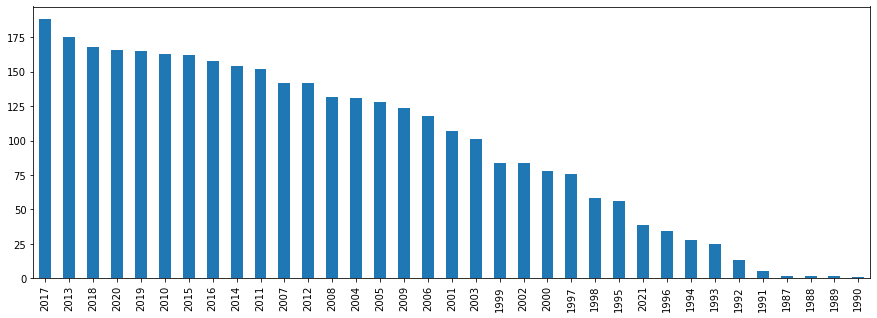

In [462]:
bib_df['year'].value_counts().plot(kind="bar", figsize=(15, 5))

Top 20 journals citing GAP.

In [253]:
top_journals = bib_df['journal'].value_counts()

In [254]:
top_20 = pd.DataFrame(top_journals.head(20))
top_20.reset_index()

,index,journal
0,J. Algebra,387
1,Comm. Algebra,207
2,J. Symbolic Comput.,104
3,Discrete Math.,88
4,J. Algebra Appl.,85
5,J. Group Theory,67
6,J. Pure Appl. Algebra,64
7,Internat. J. Algebra Comput.,64
8,Des. Codes Cryptogr.,59
9,LMS J. Comput. Math.,47


In [258]:
headers = ['Journal name', 'GAP Citations count']
print(tabulate(top_20, headers = headers, tablefmt = 'pretty'))

+------------------------------+---------------------+
|         Journal name         | GAP Citations count |
+------------------------------+---------------------+
|          J. Algebra          |         387         |
|        Comm. Algebra         |         207         |
|     J. Symbolic Comput.      |         104         |
|        Discrete Math.        |         88          |
|       J. Algebra Appl.       |         85          |
|       J. Group Theory        |         67          |
|    J. Pure Appl. Algebra     |         64          |
| Internat. J. Algebra Comput. |         64          |
|     Des. Codes Cryptogr.     |         59          |
|     LMS J. Comput. Math.     |         47          |
|     Arch. Math. (Basel)      |         44          |
|     European J. Combin.      |         42          |
|      Experiment. Math.       |         42          |
|         Math. Comp.          |         37          |
|       Algebra Colloq.        |         35          |
|     Elec

In [83]:
bib_df['ENTRYTYPE'].describe()

count        3367
unique         10
top       article
freq         2976
Name: ENTRYTYPE, dtype: object

In [120]:
bib_df['ENTRYTYPE'].value_counts()

article          2976
incollection      204
inproceedings      54
phdthesis          47
mastersthesis      46
book               31
misc                5
techreport          2
inbook              1
manual              1
Name: ENTRYTYPE, dtype: int64

##### The most frequent type of work citing GAP: we can see that GAP is predominantly cited in articles - 2976 times.

<AxesSubplot:>

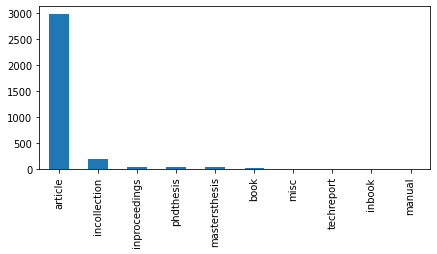

In [463]:
bib_df['ENTRYTYPE'].value_counts().plot(kind="bar", figsize=(7, 3)) # base from leccture 8 CS2006

NameError: name 'self' is not defined

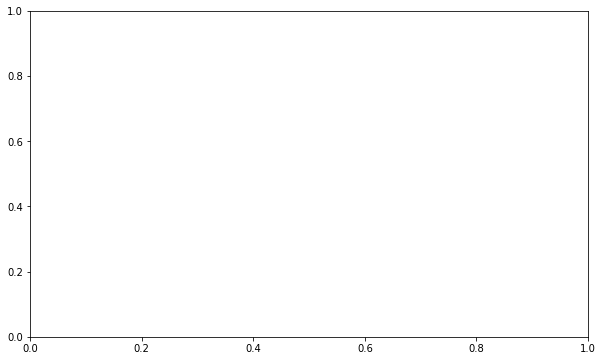

In [487]:
fig, ax = plt.subplots(figsize=(10, 6))

# Create bar plot
ax.bar(bib_df['ENTRYTYPE'], self)

plt.show()

In [154]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
interact(f, x=['apples','oranges']);

#  Corpus and Review

What are the GAP Citation practices ???

To do
+ check Citations strings lenghts to isolate too short ones
+ version
+ website
+ remaining HTML characters

Two citations containing Singapore instead of GAP present.



In [426]:
corpus_df

,MR,Citation
0,MR4056124,"GAP – Groups, algorithms, programming - a syst..."
1,MR3942387,"Delgado, M., García-Sánchez, P.A., Morais, J.:..."
2,MR3942387,"The GAP Group: GAP—groups, algorithms, and pro..."
3,MR3354065,"The GAP – Groups, Algorithms and Programming. ..."
4,MR3646312,"The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Alg..."
...,...,...
3537,MR3988630,"M. Delgado, P. A. García-Sánchez and J. Morais..."
3538,MR1801202,"L.H. Soicher, GRAPE: a system for computing wi..."
3539,MR2558870,"L. Bartholdi, Functionally recursive groups, h..."
3540,MR2824780,"X. Sun, C. Liu, D. Li and J. Gao, On duality g..."


In [436]:
# Python lectures by Dr Konovalov 
# https://studres.cs.st-andrews.ac.uk/CS2006/Lectures/Python/L08-dataset.pdf
def get_citation(mrno):
 r = corpus_df[corpus_df['MR'] == mrno]
 return [r.at[r.index[0],'Citation'], r.at[r.index[0],'Version']]

In [444]:
# Python lectures by Dr Konovalov 
# https://studres.cs.st-andrews.ac.uk/CS2006/Lectures/Python/L08-dataset.pdf
unknown_ver = []
def get_version(s):
    match = re.search("(?:(\d+\.(?:\d+\.)*\d+))", s, re.IGNORECASE)
    if match != None:
        return match.group(1)
    else:
        print('No match:', s)
        unknown_ver.append(s)

In [454]:
# Python lectures by Dr Konovalov 
# https://studres.cs.st-andrews.ac.uk/CS2006/Lectures/Python/L08-dataset.pdf
def is_package(series):
    mrno = series['MR']
    citation = series['Citation']
    version = series['Version']
    if re.search("package", citation, re.IGNORECASE) != None:
        print('***Package***:', mrno, citation)
        return 'Package'
# this way we catch cases where GRAPE is used without the word package
    elif re.search("grape", citation, re.IGNORECASE) != None: 
        print('??? GRAPE PKG ???:', mrno, citation)
        return 'GRAPE GAP Package'
    else:
        print('***Not a Package***:', mrno, citation)
        return series['Version']

First we create the version column.

In [432]:
corpus_df.insert(loc=2, column='Version', value=' ')

In [445]:
corpus_df['Version'] = corpus_df['Citation'].map(get_version)

No match: GAP – Groups, algorithms, programming - a system for computational discrete algebra, www.gap-system.org.
No match: Delgado, M., García-Sánchez, P.A., Morais, J.: "Numerical Sgps", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. Accessed 19 Aug 2017 
MR3493240
No match: M. Schönert et al. GAP - Groups, Algorithms, and Programming (Lehrsthul D für Mathematik, Reinisch-Westflische Technische Hochschule, Aachen, Germany, fifth ed., 1995.)
No match: W. Nickel, NQ, 1998, A refereed GAP 4 package, see [10].
No match: W. Nickel, NQ, 1998, A refereed GAP 4 package, see [8].
No match: Gamble, G., Nickel, W., O'Brien, E.A.: ANU p-Quotient–p-Quotient and p-Group Generation Algorithms (2006). An accepted GAP 4 package, available also in MAGMA
No match: M. Schönert et al, GAP: groups, algorithm and programming, © 1992 by Lehrstuhl D für Mathematik, distributed with the GAP software via ftp from samson.math.rwth-aachen.de.
No match: M. Delgado, P. A. G

No match: T. Breuer, GAP Computations with ${O^ + }(8,5).{S_3}$ and ${O^ + }(8,2).{S_3}$, RWTH Aachen, 2006; http://www.math.rwth-aachen.de/$\sim$Thomas.Breuer/ctbllib/htm/o8p2s3\_o8p5s3.htm.
No match: Michel, J.: Homepage of the development version of the GAP part of CHEVIE. http://www.math.jussieu.fr/$\sim$jmichel/chevie/chevie.html.
No match: The GAP Group (2002). GAP—Groups, Algorithms, and Programming, Aachen, St Andrews. Available from: http://www-gap.dcs.st-and.ac.uk/$\sim$gap.
No match: Soicher LH The DESIGN package for GAP; http://www.designtheory.org/software/gap\_design/
No match: L. H. Soicher, The DESIGN package for GAP, http: //designtheory.org /software .
No match: M. Schönert et al., GAP: Groups, algorithm and programming, Lehrstuhl D für Mathematik, RWTH Aachen, 1994.
No match: W. Nickel, NQ-nilpotent quotients of finitely presented groups (A refereed GAP 4 package) (1998). http://www.gap-system.org/Packages/nq.html
No match: Greg Gamble, Alexander Hulpke, George Havas

No match: M. Neunhöffer, Á. Seress, et al., The {\ssf GAP} package recog, a collection of group recognition methods, http://gap-packages.github.io/recog/.
No match: The GAP Group, GAP – Groups, Algorithms, and Programming, http://www.gap-system.org.
No match: D.F. Holt, The $\ssf{GAP}$ package $\ssf{kbmag}$, Knuth-Bendix on monoids and automatic groups, https://www.gap-system.org/Packages/kbmag.html.
No match: M. Neunhöffer, Á. Seress, et al., The $\ssf{GAP}$ package $\ssf{recog}$, A collection of group recognition methods, http://gap-packages.github.io/recog/.
No match: A.S. Detinko, D.L. Flannery, A. Hulpke, GAP functionality for Zariski dense groups, Oberwolfach Preprints, OWP 2017-22.
No match: The GAP Group, GAP –Groups, Algorithms, and Programming, http://www.gapsystem.org.
No match: A. S. Detinko, D. L. Flannery, and A. Hulpke, GAP Functionality for Zariski Dense Groups, Oberwolfach Preprints OWP 2017-22.
No match: The GAP Group, GAP – Groups, Algorithms, and Programming, http:/

No match: Schönert, M. et al., GAP-Groups, Algorithms and Programming; Lehrstul D Für Mathematik, RWTH, Aachen, 1992.
No match: B. Eick and W. Nickel, Polycyclic: Computation with polycyclic groups, a GAP 4 package, www.gap-system.org/Packages/polycyclic.html.
No match: M. Delgado, P. A. García-Sánchez and J. Morais, "NumericalSgps": a GAP package for numerical semigroups, http://www.gap-system.org/Packages/numericalsgps.html
No match: M. Delgado, P. A. García-Sánchez, and J. Morais, GAP package NumericalSgps: A package for numerical semigroups, 2008, available at http://www.gap-system.org/Packages/numericalsgps.html. 
MR3493240
No match: GAP: Groups, Algorithms, Programming — a system for computational discrete algebra, The GAP Group, http://www.gap-system.org.
No match: P. A. García-Sánchez and A. Sánchez-R.-Navarro, 4ti2gap, GAP wrapper for 4ti2, https://github.com/gap-packages/4ti2gap.
No match: The GAP Group, GAP - Groups, Algorithms, and Programming, 2014, http://www.gap-system.o

No match: P. N. Achar, An implementation of the generalized Lusztig-Shoji algorithm, GAP package, https://www.math.lsu.edu/~pramod/resources.html, 2008.
No match: Lehrstuhl D für Mathematik, RWTH Aachen, GAP, computer program, available from http://www-gap.dcs.st-and.ac.uk/$\sim$gap.
No match: Lehrstuhl D für Mathematik, RWTH Aachen, GAP, computer program. Available from: http://www-gap.dcs.st-and.ac.uk/$\sim$gap.
No match: V. Felsch, D. F. Holt and W. Plesken, `Perfect groups—GAP data library', 2018, https://www.gap-system.org/Datalib/perfect.html. 
MR1025760
No match: Polyhedral – a GAP package, by M. Dutour Sikirić, http://www.liga.ens.fr/~dutour/Polyhedral/index.html.
No match: GAP, Groups, Algorithms and Programming, Version 4–3. The GAP Group, Lehrstuhl D für Mathematik, RWTH Aachen, Germany and School of Mathematical and Computational Sciences, University of St. Andrews, Scotland, http://www-gap.dcs.st-and.ac.uk/$\sim$gap/ 2002.
No match: GAP. Groups, Algorithms and Programming,

No match: Martin Schönert et al. (1997), GAP - Groups, Algorithms and Programming. Lehrstuhl D für Mathematik, RWTH Aachen.
No match: Bettina Eick, Werner Nickel, Polycyclic, 2000, A GAP package, see [GAP05].
No match: The GAP Group, GAP—Groups, Algorithms, and Programming, http://www.gap-system.org.
No match: The GAP group, GAP - groups, algorithms, and programming, http://www.gap-system.org.
No match: The GAP Group, GAP—Groups, Algorithms, and Programming, http://www.gap-system.org.
No match: GAP Group, GAP—Groups, algorithms, programming (2013) Available at http://www.gap-system.org
No match: M. Schönert et al., `GAP - Groups, algorithms and programming', RWTH Aachen: Lehrstuhl D für Mathematik, 5th edn, 1995 (http://www.gap.dsc.st-and.ac.uk/gap).
No match: `GAP—groups, algorithms, programming—a system for computational discrete algebra', http://www.gap-system.org/.
No match: Ellis, G. (2010). HAP-Homological Algebra Programming. A refreed GAP 4 package (GAP Group 2008), available a

No match: The GAP Group, GAP–Groups, algorithms, programming–A system for computational discrete algebra. http://www.gap-system.org/
No match: G. P. Nagy and P. Vojtěchovský, LOOPS–Computing with quasigroups and loops in GAP. http://www.math.du.edu/loops/
No match: The GAP group, GAP–groups, algorithms, programming–a system for computational discrete algebra. http://www.gap-system.org/.
No match: GAP—Groups, algorithms, programming—a system for computational discrete algebra, http://www.gap-system.org/.
No match: G. P. Nagy and P. Vojtěchovský, LOOPS—computing with quasigroups and loops in GAP, http://www.math.du.edu/loops/.
No match: G.P. Nagy, P. Vojtěchovský, LOOPS—Computing with quasigroups and loops in GAP, http://www.math.du.edu/loops/.
No match: The GAP Group, GAP—Groups, algorithms, programming—a system for computational discrete algebra. http://www.gap-system.org/.
No match: Gábor P. Nagy and Petr Vojtěchovský, LOOPS: Computing with quasigroups and loops in GAP, available at h

In [446]:
corpus_df['Version'].value_counts()

4.4       460
4.4.12    310
4.3       232
4.4.10    136
4.2       127
         ... 
3.1.3       1
1.7         1
2.22        1
1.9.6       1
4.6.12      1
Name: Version, Length: 196, dtype: int64

Then we apply the function which chekcs if it is a case of citing GAP Package. Packages are connected to GAP, but technically is a separate piece of software.

In [448]:
corpus_df['Version'] = corpus_df.apply(is_package,axis=1)

*** No match: MR4056124 GAP – Groups, algorithms, programming - a system for computational discrete algebra, www.gap-system.org.
??? PKG ???: MR3942387 Delgado, M., García-Sánchez, P.A., Morais, J.: "Numerical Sgps", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. Accessed 19 Aug 2017 
MR3493240
*** No match: MR3942387 The GAP Group: GAP—groups, algorithms, and programming, version 4.7.5 (2014). http://www.gap-system.org. Accessed 19 Aug 2017
*** No match: MR3354065 The GAP – Groups, Algorithms and Programming. Version 4.4.12, 2008. www.gap-system.org.
*** No match: MR3646312 The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Algorithms, and Programming, 4.7.8, 2015, http://www.gap-system.org.
*** No match: MR1864795 M. Schönert et al. GAP - Groups, Algorithms, and Programming (Lehrsthul D für Mathematik, Reinisch-Westflische Technische Hochschule, Aachen, Germany, fifth ed., 1995.)
*** No match: MR2287843 The GAP Group, GAP - Groups, Algorithms, and Prog

*** No match: MR2501429 GAP: Groups, Algorithms, and Programming, Version 4.4.10 (2007). http://www.gap-system.org
*** No match: MR2967225 The GAP Group. GAP - Groups, Algorithms, and Programming, Version 4.4.12, 2008. http://www.gap-system.org.
*** No match: MR3898216 GAP – groups, algorithms and programming, version 4.7.4 (2014), http://www.gap-system.org.
*** No match: MR2728929 GAP: A System for Computational Discrete Algebra, http://www.gap-system.org.
*** No match: MR2533593 The GAP Group, GAP—Groups, Algorithms, and Programming. Version 4.4.2 (2004), http://www.gap-system.org.
*** No match: MR1991706 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.2; Aachen, St Andrews, 1999. (http://www-gap.dcs.st-and.ac.uk/$\sim$gap).
*** No match: MR3497178 The GAP Group (GAP Groups, Algorithms, and Programming), Version 4.4.12. http://www.gap-systein.org
*** No match: MR1760973 M. Schönert, T. Breuer, F. Celler, S. Linton, B. Eick, V. Felsch, W. de Graaf, A. Hulpke, W. Nick

*** No match: MR3133699 The GAP Group, GAP—Groups, Algorithms and Programming, Version 4.4.12, (2008), http://www.gap-system.org.
*** No match: MR3677868 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.7.8 (2015). http://www.gap-system.org.
*** No match: MR2799090 The GAP Group. GAP-Groups, Algorithms, and Programming, version 4.4.12, http://www.gap-system.org. 2008.
??? PKG ???: MR2799090 M. Graña and L. Vendramin, RiG, A GAP package for racks and Nichols Algebras, available at http://mate.dm.uba.ar/~lvendram.
*** No match: MR2745542 T. Breuer, The GAP Character Table Library, Version 1.2 (unpublished), http://www.math.rwth-aachen.de/$\sim$Thomas.Breuer/ctbllib/.
*** No match: MR2745542 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4.12, 2008, available at http://www.gapsystem.org.
??? PKG ???: MR2745542 R.A. Wilson, R.A. Parker, S. Nickerson, J.N. Bray, T. Breuer, AtlasRep, A GAP Interface to the ATLAS of Group Representations, Version 1.4, r

??? PKG ???: MR2358616 W. Nickel, NQ, 1998, A refereed GAP 4 package, see [23].
*** No match: MR2358616 The GAP Group, GAP—Groups, algorithms and programming, http://www.gap-system.org, 2006.
*** No match: MR3095137 The GAP Group.: Gap—groups, algorithms, and programming, (http://www.gap-system.org) Version 4.4 (2002)
*** No match: MR2899926 The GAP Group. (2008). GAP-Groups, Algorithms, and Programming. Version 4.4.12 Available at http://www.gap-system.org.
*** No match: MR2949209 The GAP group, GAP—Groups, Algorithms, and Programming, Version 4.4.12 (2008), http://www.gap-system.org.
*** No match: MR2748335 TG Group, GAP - Groups, Algorithms and Programming, version 4.4.10 (2007) Available at http://www.gap-system.org/
*** No match: MR2520526 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4; 2005 (http://www.gap-system.org).
*** No match: MR3851116 The GAP Group, GAP–Groups, Algorithms, and Programming. Version 4.8.2 (2016). http://www.gap-system.org
*** No match: 

*** No match: MR3361643 The GAP group, `GAP–groups, algorithms, and programming, Version 4.4.12', 2008, http://www.gap-system.org.
*** No match: MR3386519 The GAP Group. GAP – Groups, Algorithms, and Programming, Version 4.3. http://www.gap-system.org: 2002.
??? PKG ???: MR3092787 Ballester-Bolinches A., Cosme-Llópez E., Esteban–Romero R., Permut: A GAP4 package to deal with permutability, v.0.03, available at http://personales.upv.es/$\sim$resteban/gap/permut-0.03/
*** No match: MR3092787 The GAP Group, GAP–Groups, Algorithms, Programming, v. 4.5.7, 2012
*** No match: MR1941921 The GAP Group, Aachen, St Andrews. GAP–Groups, Algorithms, and Programming, Version 4.1, 1999. (http://www-gap.dcs.st-and.ac.uk/$\sim$gap).
*** No match: MR3658297 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.6, November 2016. http://www.gap-system.org.
*** No match: MR3893365 The GAP Group, GAP – groups, algorithms, and programming, version 4.7.8, http://www.gap-system.org, 2015.
*** N

*** No match: MR3939267 The GAP Group, `GAP–groups, algorithms, and programming, version 4.8.6', 2016, http://www.gap-system.org.
*** No match: MR4079645 The GAP Group, GAP—Groups, Algorithms and Programming, Vers. 4.7.7; (2015). (http://www.gapsystem.org)
??? PKG ???: MR4160306 S. Doty, WeylModules, a GAP package, Version 1.1, 2009, http://doty.math.luc.edu/weylmodules.
*** No match: MR4160306 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.10, 2018, https://www.gap-system.org.
*** No match: MR2655289 The $\ssf{GAP}$ Group, $\ssf{GAP}$ - Groups, Algorithms and Programming, Version 4.4.12, available at http://www.gap-system.org.
??? PKG ???: MR2171086 E. Aichinger, F. Binder, J. Ecker, P. Mayr, C. Nöbaner, SONATA—system of near-rings and their applications, Package for the group theory system GAP4, 2002.
*** No match: MR2062999 The GAP Group. GAP—Groups, Algorithms, and Programming, Version 4.2 (Aachen, St Andrews, 2000) (http://www-gap.dcs.st-and.ac.uk/$\sim$gap)

*** No match: MR2974230 The GAP Group. GAP–Groups, Algorithms, and Programming, Version 4.4.12, 2008. (http://www.gap-system.org).
*** No match: MR3420524 The GAP Group. GAP – Groups, Algorithms, and Programming, Version 4.6.4 (2013) http://www.gap-system.org
*** No match: MR3599003 GAP – Groups, Algorithms, and Programming, Version 4.7.6. "The GAP Group." Available online (http://www.gap-system.org), 2015.
*** No match: MR3833453 The GAP Group, GAP – Groups, Algorithms, and Programming, version 4.8.5, http://www.gap-system.org, 2016.
*** No match: MR3200071 The GAP Group. (2008). GAP–Groups, Algorithms, and Programming, Version 4.4.12. (http://www.gap-system.org)
*** No match: MR4194284 The GAP Group, GAP: groups, algorithms, and programming, software (2017) Version 4.8.8 Available at https://www.gap-system.org
*** No match: MR1736751 Martin Schönert et al. (1994), GAP–Groups, Algorithms and Programming, Lehrstuhl D für Mathematik, RWTH, Aachen.
*** No match: MR2107948 The GAP Group, 

*** No match: MR2831228 The GAP group, `GAP-groups, algorithms, and programming, version 4.4.2' (2004), available for download from http://www.gap-system.org.
*** No match: MR2669683 T. Breuer, `GAP computations concerning Hamiltonian cycles in the generating graphs of finite groups', Preprint, 2009, arXiv:0911.5589.
*** No match: MR2669683 The GAP group, '`GAP—groups, algorithms and programming, version 4.4', 2005, http://www.gapsystem.org.
*** No match: MR3682588 T. Breuer, The $\ssf{GAP}$ Character Table Library, Version 1.2.2; 2013, http://www.math.rwth-aachen.de/~Thomas.Breuer/ctbllib.
*** No match: MR3682588 The GAP Group, $\ssf{GAP}$ – Groups, Algorithms, and Programming, Version 4.7.7; 2015, http://www.gap-system.org.
*** No match: MR3682588 R. A. Wilson et al., $\ssf{AtlasRep}$, a $\ssf{GAP}$ Interface to the Atlas of Group Representations, Version 1.5.1; 2016, http://www.math.rwth-aachen.de/~Thomas.Breuer/atlasrep.
??? PKG ???: MR3985485 T. Breuer, CTblLib, The GAP Character 

*** No match: MR4075374 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.10.0 (2018). http://www.gap-system.org
*** No match: MR2224458 The GAP Group, GAP–Groups, Algorithms and Programming, version 4.2 (2000) http://www-gap.dcs.st-and.ac.uk/$\sim$gap/
*** No match: MR3141730 Michel, J.: Homepage of the development version of the GAP part of CHEVIE. http://www.math.jussieu.fr/$\sim$jmichel/chevie/chevie.html.
*** No match: MR2255427 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3, 2002, http://www.gap-system.org
*** No match: MR2009400 The GAP Group (2002). GAP—Groups, Algorithms, and Programming, Aachen, St Andrews. Available from: http://www-gap.dcs.st-and.ac.uk/$\sim$gap.
*** No match: MR1943939 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.2; 2000, http://www. gap-system.org.
*** No match: MR2176659 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3; Aachen, St. Andrews, 2002, http://www-gap.dcs.st-and.ac.uk/

*** No match: MR3824577 The GAP Group, GAP — Groups, Algorithms, and Programming, Version 4.5.5. (2012). http://www.gap-system.org
*** No match: MR3941099 GAP – Groups, Algorithms, and Programming, Version 4.5.5, 2012, http://www.gap-system.org.
*** No match: MR2523842 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4. (2006). http://www.gap-system.org
*** No match: MR4203538 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.10.2, https://www.gap-system.org, 2019.
*** No match: MR3505332 The GAP Group.: GAP—Groups, Algorithms, and Programming, Version 4.4.12 (2008). http://www.gap-system.org
*** No match: MR1831996 G. Havas - M. F. Newman - E. A. O'Brien, ANU $p$-Quotient Program, Version 1.2, written in C, available from maths.anu.edu.au by anonymous ftp in the directory /pub/PQ, as a share library with GAP 3.4 and as part of Magma (1995).
*** No match: MR1831996 M. Schönert et al., GAP - Groups, Algorithms and Programming, Release 3.4, Lehrstuhl D 

*** No match: MR3253967 The GAP Group, GAP—groups, algorithms, and programming, version 4.4.12 (2008), http://www.gap-system.org.
??? PKG ???: MR3253967 L. Vendramin, RIG—a GAP package for racks and quandles (2011), http://code.google.com/p/rig/.
*** No match: MR2134762 http://www.math.rwth-aachen.de/~GAP.
*** No match: MR1808349 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4b5, Aachen, St. Andrews, 1998 [http://www-gap.dcs.st-and.ac.uk/$\sim$gap]
*** No match: MR2047097 The GAP Group, Aachen, St Andrews, GAP – Groups, Algorithms, and Programming, Version 4.1, 1999 (http://www.gap-system.org).
??? PKG ???: MR2124811 A.M. Cohen, D.A.H. Gijsbers, GBNP, a GAP package for Gröbner bases computations with noncommutative polynomials, Eindhoven, http://www.win.tue.nl/amc/ow/grobner/doc/, 2002.
*** No match: MR2141659 Martin Schönert et al.: GAP - Groups, Algorithms, and Programming, Rheinisch Westfälische Technische Hochschule, Aachen, 1995.
*** No match: MR2531218 The GAP G

*** No match: MR2440718 M. Schönert et al., GAP-groups, algorithms and programming, Lehrstuhl De für Mathematik (1995) (http://www.gap-system.org).
*** No match: MR2852917 The GAP Group, GAP–Groups, Algorithms, and Programming, version 4.4.12, 2008. http://www.gap-system.org
*** No match: MR3102179 F. Effenberger, J. Spreer, simpcomp - A GAP toolkit for simplicial complexes, version 1.5.4, http://www.igt.uni-stuttgart.de/LstDiffgeo/simpcomp, 2011.
*** No match: MR1946634 Schönert, M. (together with, Bessche, H. U. et al.), (1997). updated by S. A. Linton, GAP: Groups Algorithms and Programming v. 3.4.4. Distributed Electronically with GAP, 18 April 1997.
??? PKG ???: MR3852764 Delgado, M., Linton, S., Morais, J.: Automata – a GAP package, Version 1.13. http://cmup.fc.up.pt/cmup/mdelgado/automata/ (2011)
*** No match: MR3852764 The GAP Group: GAP – Groups, Algorithms, and Programming, Version 4.8.6 (2016). http://www.gap-system.org
*** No match: MR3224085 M. Alp and C. D. Wensley, XMOD,

*** No match: MR3534775 The GAP Group: GAP - Groups, Algorithms, and Programming, Version 4.7.9 (2015). www.gap-system.org
*** No match: MR2130175 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.2 (2000) http://www.gap-system.org.
*** No match: MR1747822 M. Schönert et. al., GAP Groups, Algorithms, and Programming, 5th edn., Lehrstuhl D Math., Rheinisch Westfällische Techn. Hochsch., Aachen, (1995).
*** No match: MR2094812 A. S. Detinko, A new GAP group library for irreducible maximal solvable subgroups of prime degree classical groups, J. Math. Sci. 108 (2002), 942–950. 
MR1747822
??? PKG ???: MR2556145 A.S. Detinko, B. Eick, D.L. Flannery, Nilmat - Computing with nilpotent matrix groups. A refereed GAP 4 package, see http://www.gap-system.org/Packages/nilmat.html, 2007.
??? PKG ???: MR2381967 Assmann, B., Eick, B., 2007a. Polenta-Polycyclic presentations for matrix groups. A refereed GAP 4 package. See http://www.gap-system.org/Packages/polenta.html.
??? PKG ???: MR

*** No match: MR3005071 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.4.12; 2008, http://www.gap-system.org.
*** No match: MR3816217 The GAP Group: GAP—Groups, Algorithms and Programming, Version 4.4. https://www.gap-system.org (2006).
*** No match: MR2794530 `GAP - Groups, Algorithms, Programming', Version 4.2, 2000, http://www-gap.dcs.st-and.ac.uk/$\sim$gap.
*** No match: MR2894605 GAP—Groups, Algorithms, and Programming, version 4.2, 2000, see http://www-gap.dcs.st-and.ac.uk/ gap.
*** No match: MR3053525 GAP-Groups, Algorithms, and Programming, Version 4.2, 2000 (http://www-gap.dcs.st-and.ac.uk/$\sim$gap).
*** No match: MR3261872 GAP-Groups, Algorithms, and programming, Version 4.2, 2000, http://www-gap.dcs.st-and.ac.uk/$\sim$gap.
*** No match: MR3314295 GAP-groups, algorithms, and programming, version 4.2, http://www-gap.dcs.st-and.ac.uk/$\sim$gap, 2000.
??? PKG ???: MR3314295 W.A. de Graaf, SLA-computing with simple Lie algebras. A GAP package, http://www.sci

*** No match: MR2268360 The GAP Group, `GAP – Groups, algorithms, and programming', Version 4.3, 2002, http://www.gap-system.org.
*** No match: MR1854332 The GAP Group, Aachen, St Andrews, GAP - Groups, Algorithms, and Programming, Version 4.1, 1999. (http://www-gap.dcs.st-and.ac.uk/$\sim$ gap).
*** No match: MR2015107 The GAP Group, 2002. GAP—Groups, Algorithms, and Programming, Version 4.3, St. Andrews, Aachen. Available from: http://www.gap-system.org.
??? PKG ???: MR3181226 G.P. Nagy, P. Vojtěchovský, LOOPS-A GAP Package, Version 2.1.0, December 2008. http://www.math.du.edu/loops/.
*** No match: MR3181226 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4.12, 2008. http://www.gap-system.org.
*** No match: MR3089324 GAP-Groups, Algorithms and Programming (http://www.gap-system.org).
*** No match: MR2920888 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.12, 2008, www.gap-system.org.
*** No match: MR3161112 The GAP group, GAP - Groups, algorithms,

??? PKG ???: MR3896314 L. Vendramin, Rig — a GAP package for racks, quandles and Nichols algebras, version 0.6 (2011), http://github.com/vendramin/rig/.
*** No match: MR2743136 GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4.10 (2007), http://www.gap-system.org
??? PKG ???: MR2743136 L. Soicher, GRAPE—a GAP package, Version 4.3 (2006), http://www.maths.qmul.ac.Uk/$\sim$ leonard/grape.
*** No match: MR3408045 GAP, GAP-groups, algorithm and programming, 2002, Software available online at http://www.gap-system.org.
*** No match: MR3071135 T G Group, GAP–Groups, Algorithms, and Programming, Version 4.4.12 Available at http://www.gap-system.org
*** No match: MR2377237 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4; 2004, (http://www.gap–system.org).
*** No match: MR3614517 The GAP group, "GAP - Groups, Algorithms, Programming - version 4.7.", http://www.gap-system.org/.
*** No match: MR2469351 T. Breuer, J. Müller, Character tables of endomorphism rings 

*** No match: MR2059528 The GAP Group. GAP–Groups, Algorithms, and Programming, Version 4.3, 2002. (http://www.gap-system.org).
*** No match: MR3030511 The GAP Group, GAP - groups, algorithms and programming, version 4.4.12, http://www.gap-system.org, 2008.
??? PKG ???: MR3030511 D. Traytel, GAP 4 package Hecke, version 1.3, http://home.in.tum.de/$\sim$traytel/hecke/, 2010.
*** No match: MR1935417 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.2, Aachen, St Andrews, 2000, (http://www-gap.dcs.st-and.ac.uk/~gap).
??? PKG ???: MR3511292 M. Delgado, P. A. Garciá-Sánchez, and J. Morais, NumericalSgps, A GAP package for numerical semigroups. Available via http://www.gap-system.org.
*** No match: MR3511292 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.7.7, 2015.
*** No match: MR4171682 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.8.10, https://www.gap-system.org, 2018.
*** No match: MR3053516 The GAP Group, GAP—Groups, Algorith

*** No match: MR4135543 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.10.0, https://www.gap-system.org, 2018.
*** No match: MR4135543 M. Geck, ChevLie — constructing Lie algebras and Chevalley groups in GAP, available at http://www.math.rwth-aachen.de/~CHEVIE/contrib.html, July 2016.
??? PKG ???: MR4135543 J. Michel, The development version of the CHEVIE package of GAP3, J. Algebra 435 (2015) 308–336, Webpage at https://webusers.imj-prg.fr/~jean.michel/chevie/chevie.html. 
MR3343221
*** No match: MR4089050 The GAP Group. GAP – Groups, Algorithms, and Programming. Version 4.10.0, 2018. Available at http://www.gap-system.org.
*** No match: MR1800032 Schönert, M. et al. (1997). GAP 3.4, patchlevel 4. School of Mathematical and Computational Sciences, University of St Andrews, Scotland.
*** No match: MR3360898 The GAP Group. GAP - Groups, Algorithms, and Programming, Version 4.7.2; 2013, http://www.gap-system.org.
*** No match: MR3958746 GAP GAP–Groups, Algorithms, an

*** No match: MR3898507 The GAP Group, Groups, Algorithms, and Programming, http://www.gap-system.org (2008).
*** No match: MR3582425 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.7.8; (2016). http://www.gap-system.org
*** No match: MR4166354 The GAP Group, GAP—Groups, algorithms, and programming, Version 4.4.12, 2008, available at https://www.gap-system.org
??? PKG ???: MR4166354 G. P. Nagy and P. Vojtěchovský, LOOPS—a GAP package, version 2.1.0, 2008, available at https://gap-packages.github.io/loops/
*** No match: MR2733828 Groups, Algorithms, Programming—A System for Computational Discrete Algebra (GAP) http://www.gap-system.org
*** No match: MR3162960 Groups, Algorithms, Programming—A System for Computational Discrete Algebra (GAP) http://www.gap-system.org
??? PKG ???: MR3162960 Besche H U, Eick B and O'Brien E A 2002 SmallGroups—A GAP package www.gap-system.org/Packages/sgl.html
*** No match: MR2155504 The GAP Group, GAP–Groups, Algorithms, and Programming, V

*** No match: MR2043998 The GAP Group. GAP–Groups, Algorithms, and Programming, Version 4.3. Available from World Wide Web (http://www.gap-system.org), 2003.
??? PKG ???: MR2043998 G. Havas, C. Ramsay, G. Gamble, and A. Hulpke. "ACE: A GAP 4 Package Providing an Interface to the Advanced Coset Enumerator." Available from World Wide Web (http://www.gap-system.org/Share/ace.html), 2003.
??? PKG ???: MR2101831 Gamble, G., Havas, G., Hulpke, A. (2002). PGRelFind: a GAP example using the ACE share package. {http://www.gap-system.org/-gap/Intro/pgrelfind.html} (accessed September 2002).
*** No match: MR2228634 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, 2004, http://www.gap-system.org/.
*** No match: MR2160572 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4 (2004), http://www.gap-system.org.
*** No match: MR2476442 The GAP Group, GAP Groups, Algorithms, and Programming, Version 4.4, 2004. See also http://www.gap-system.org/.
*** No match: MR2531

*** No match: MR2039809 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3, 2002. Available from: $<$http://www.gap-system.org$>$.
??? PKG ???: MR3096858 G. P. Nagy and P. Vojtěchovský, LOOPS: Computing with quasigroups and loops, version 2.0.0, package for GAP, http://www.math.du.edu/loops.
*** No match: MR2375471 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org (2005), Accessed 31 October 2007.
*** No match: MR2375471 Gamble G., Havas G., Hulpke A., Ramsay C.: ACE: a GAP 4 interface to the Advanced Coset Enumerator of G. Havas and C. Ramsay. http://www.math.rwth-aachen.de/$\sim$Greg.Gamble/ACE/, (2000), Accessed 31 October 2007.
*** No match: MR3510826 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.6.3; 2013, (http://www.gap-system.org).
??? PKG ???: MR3510826 W. Gamble, A. Hukpke, G. Havas and C. Ramsay, ACE – Advanced coset enumerator, A refereed GAP 4 package, see [7].
??? PKG ???: MR3510826 D. Hol

*** No match: MR2724218 The GAP Group. (2004). GAP–Groups, Algorithms, and Programming. Version 4.4. http://www.gap-system.org.
??? PKG ???: MR2724218 Nagy, G. P., Vojtěchovský, P. LOOPS: Computing with Quasigroups and Loops. Version 2.0.0. Package for GAP, http://www.math.du.edu/loops.
*** No match: MR2859875 GAP Group, GAP - Groups, algorithms, and programming, version 4.4.10, 2007, http://www.gap-system.org.
??? PKG ???: MR2859875 G. Nagy, P. Vojtěchovský, LOOPS: Computing with quasigroups and loops in GAP - a GAP package, version 2.0.0, 2008, http://www.math.du.edu/loops. 
MR2379126
*** No match: MR3400403 The GAP Group, GAP – groups, algorithms, and programming, version 4.5.5, available at http://www.gap-system.org, 2012.
*** No match: MR3584827 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.5.5; 2012. http://www.gap-system.org.
*** No match: MR3584827 G.P. Nagy and P. Vojtěchovský, LOOPS: Computing with quasigroups and loops in GAP, version 2.2.0, http://www.ma

*** No match: MR3891940 The GAP Group, `GAP—groups, algorithms, and programming, version 4.9.1', 2018, https://www.gap-system.org.
*** No match: MR2354797 The GAP Group. GAP—Groups, Algorithms, and Programming, version 4.4 2006. Available at http://www.gap-system.org.
*** No match: MR3422470 GAP: GAP – Groups, Algorithms, and Programming, Version 4.6.5. The GAP Group. www.gapsystem.org (2013)
*** No match: MR3422470 GAP. GAP - Groups, Algorithms, and Programming, Version 4.8.4. http://www.gap-system.org (2016)
*** No match: MR3723122 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.6.5, 2013, www.gapsystem.org.
*** No match: MR3936683 GAP, GAP – Groups, Algorithms, and Programming, Version 4.8.4 http://www.gap-system.org, Jun 2016.
*** No match: MR3910669 GAP, GAP — Groups, Algorithms, and Programming, Version 4.8.4. http://www.gap-system.org, Jun 2016.
??? PKG ???: MR3910669 R. A. Wilson, R. A. Parker, S. Nickerson, J. N. Bray and T. Breuer, AtlasRep, a gap interfac

*** No match: MR3589145 GAP — Groups, Algorithms, and Programming, Ver. 4.4.12 (2008), http://www.gap-system.org.
*** No match: MR3666011 The GAP Group, GAP–Groups, Algorithms, Programming, a System for Computational Discrete Algebra, Vers. 4.8.2 (2016); http://www.gap-system.org.
??? PKG ???: MR2339852 B. Eick and E. O'Brien, GAP4 Package AutPGrp, http://www.tu-bs.de/$\sim$beick/so.html.
*** No match: MR2339852 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org, 2006.
*** No match: MR2831968 Götz Pfeiffer. Character tables of Weyl groups in GAP. Bayreuth. Math. Schr. 47 (1994), 165–222. 
MR1285208
??? PKG ???: MR2831968 Götz Pfeiffer, ZigZag—A GAP3 Package for Descent Algebras of Finite Coxeter Groups, Version 0.77 (2010). http://schmidt.nuigalway.ie/zigzag.
*** No match: MR2831968 Martin Schönert et al. GAP—Groups, Algorithms, and Programming (1995). http://www.gap-system.org.
*** No match: MR2728629 GAP: a System for Computational Discre

??? PKG ???: MR3005645 FinInG: A GAP Package for Finite Incidence Geometry, 2012. Available at http://cage.ugent.be/geometry/fining
*** No match: MR3005645 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.12; 2008. Available at http://www.gap-system.org
??? PKG ???: MR3302665 Bamberg J., Betten A., Cara P., De Beule J., Lavrauw M., Neunhoeffer M.: FinInG-a GAP package for finite incidence geometry, 1.01. http://cage.ugent.be/geometry/fining (2012). Accessed 29 July 2013.
*** No match: MR3302665 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.6.2. http://www.gap-system.org (2013). Accessed 29 July 2013.
*** No match: MR3327136 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.6.2, http://www.gap-system.org, 2013.
??? PKG ???: MR3327136 J. Bamberg, A. Betten, P. Cara, J. De Beule, M. Lavrauw, M. Neunhoeffer, FinInG - a GAP package for Finite Incidence Geometry, 1.01, http://cage.ugent.be/geometry/fining, 2014.
??? PKG ???: MR3484742 Fi

*** No match: MR1837671 The GAP group, GAP: Groups, algorithms, and programming, Version 4.2, RWTH Aachen and University of St. Andrews, 2000. See http://www-gap.dcs.st-and.ac.uk/$\sim$gap.
*** No match: MR1837968 Martin Schönert et al. GAP–Groups, Algorithms, and Program- ming. Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, third edition, 1993–1997.
*** No match: MR1876312 The GAP Group (1999). GAP—Groups, Algorithms, and Programming, Version 4.2, (see http://www.gap-system.org).
??? PKG ???: MR1876312 Lübeck, F. (1999). EDIM—Elementary Divisors and Integer Matrices, RWTH Aachen, Lehrstuhl D für Mathematik, (a refereed share package for GAP (1999), see http://www.gap-system.org/share/edim.html).
*** No match: MR2356848 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4.7, http://www.gap-system.org, 2006.
*** No match: MR3682589 T. Breuer, CTblLib, the $\ssf{GAP}$ character table library, version 1.1.3 ed., Mar 2004, http:/

??? PKG ???: MR3853073 A. Bächle, L. Margolis, HeLP–A GAP-package for torsion units in integral group rings, preprint, arXiv:1507.08174, 2015, 6 pp. 
cf. MR3820369
*** No match: MR3853073 The GAP Group, GAP – groups, algorithms, and programming, version 4.8.1, http://www.gap-system.org, 2016.
??? PKG ???: MR3853073 S. Gutsche, 4ti2 interface, http://homalg-project.github.io/homalg__project/4ti2Interface, 2015, GAP package, version 2015.11.06.
??? PKG ???: MR3951554 Bächle, A., Margolis, L., 2017a. HeLP – Hertweck-Luthar-Passi method, GAP package, Version 3.1. http://homepages.vub.ac.be/abachle/help/. 
MR3820369
??? PKG ???: MR3951554 Bächle, A., Margolis, L., 2018. HeLP: a GAP package for torsion units in integral group rings. J. Softw. Algebra Geom. 8, 1–9. 
MR3820369
??? PKG ???: MR3951554 Breuer, T., 2012. The GAP Character Table Library, Version 1.2.1. GAP package. http://www.math.rwth-aachen.de/~Thomas.Breuer/ctbllib.
*** No match: MR3951554 The GAP Group, 2017. GAP – Groups, Algo

*** No match: MR3385752 The GAP Group, GAP-Groups, Algorithms and Programming, Version 4.7.5, 2014, (http://www.gap-system.org/).
*** No match: MR3508661 The GAP Group, GAP-Groups, Algorithms and Programming, Version 4.4.12, www.gap-system.org, 2008.
*** No match: MR2228516 The GAP group, GAP-Groups, Algorithms, and Programming, Version 4.3, Aachen, St Andrews (2002) http://www.gap-system.org.
*** No match: MR2441479 GAP, Groups, Algorithms and Programming, Version 4.3, 2002 (http://www.gap-system.org/).
*** No match: MR3567881 The GAP Group, GAP-Groups, Algorithms and Programming. Version 4.7.5, 2014, http://www.gap-system.org/.
*** No match: MR2845566 GAP. (2009). Groups, Algorithms, and Programming. Version 4.4.12. Available at www.gap-system.org.
*** No match: MR3120054 Groups, Algorithms, and Programming (GAP), Version 4.4.12. http://www.gap-system.org (2009)
*** No match: MR3770014 The GAP Group: GAP — Groups, Algorithms, and Programming. Version 4.8.7, released on 24 March 2017,

??? PKG ???: MR2459358 G.P. Nagy, P. Vojtěchovský, LOOPS: Package for GAP, Version 0.99. http://www.math.du.edu/loops/, 2004.
*** No match: MR2355056 The GAP Group, 2006. GAP—Groups, Algorithms, and Programming, Version 4.4; Aachen, St Andrews (Visit http://www-gap.dcs.st-and.ac.uk/$\sim$gap).
*** No match: MR2355056 Nagy, G.P., Vojtěchovský, P., 2007. LOOPS: Computing with quasigroups and loops in GAP, download at http://www.math.du.edu/loops. 
MR2379126
??? PKG ???: MR3269010 Cicalò S., de Graaf W.A., Schneider C., LieAlgDB–a GAP package, Version 2.1, November 2010, http://www.gap-system.org/Packages/liealgdb.html.
*** No match: MR3205815 GAP Group: GAP—Groups, Algorithms, and Programming, Version 4r5. University of St Andrews and RWTH Aachen (2012).
??? PKG ???: MR3205815 Soicher L.H.: The GRAPE package for GAP, Version 4.6.1. http://www.maths.qmul.ac.uk/$\sim$leonard/grape/ (2012). Accessed 11 July 2013.
*** No match: MR3391529 The GAP Group: GAP–Groups, Algorithms, and Programming

*** No match: MR1625479 M. Schönert et al., `GAP - Groups, algorithms and programming', RWTH Aachen: Lehrstuhl D für Mathematik, 5th edn, 1995 (http://www.gap.dsc.st-and.ac.uk/gap).
*** No match: MR2142090 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.3 (2002) http://www.gap-system.org.
*** No match: MR2228649 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org, 2004.
*** No match: MR2377115 The GAP group, `GAP–groups, algorithms and programming, version 4.3', 2002, http://www.gap-system.org.
*** No match: MR2960227 `GAP—groups, algorithms, programming—a system for computational discrete algebra', http://www.gap-system.org/.
??? PKG ???: MR3259608 M. Neunhöffer and Á. Seress. GAP package recog, version 1.2. Technical report, 2012. URL (http://www.gap-system.org/Packages/recog.html).
*** No match: MR1941689 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.1; Aachen, St Andrews, 1999. (http://www-gap.dcs.st-a

*** No match: MR1829749 The GAP group (Aachen, St. Andrews), GAP-Groups, Algorithms and Programming, version 4.2, 1999.
*** No match: MR2644429 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.9; 2006 (http://www.gap-system.org).
*** No match: MR3162438 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.4.12 (2008). http://www.gap-system.org
??? PKG ???: MR3162438 Nagy, G.P., Vojtěchovský, P.: LOOPS: Computing with quasigroups and loops, Version 2.0.0. http://www.math.du.edu/loops. Package for GAP
*** No match: MR2403651 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4, 2006, http://www.gap-system.org.
*** No match: MR2480297 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.4, 2006 (http://www.gap-system.org).
*** No match: MR3021414 GAP Group, The, GAP: Groups, Algorithms, and Programming, Version 4.4 (2006; available at www.gap-system.org).
*** No match: MR2228639 M. Schönert, et al., GAP—Groups, Algorithms and P

*** No match: MR3829530 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.8.10; 2018, (http://www.gap-system.org).
*** No match: MR3694455 The GAP Group, GAP—groups, algorithms, and programming, Version 4.8.6, http://www.gap-system.org, 2016.
*** No match: MR3798189 The GAP Team., GAP - Groups, Algorithms, and Programming. Version 4.5.5, 2012. Available online (http://www.gap-system.org).
*** No match: MR4165604 The GAP Team, GAP - Groups, Algorithms, and Programming, Version 4.10.1, 2019, http://www.gap-system.org.
*** No match: MR2478421 The {\ssf GAP} Group, {\ssf GAP}-Groups, Algorithms, and Programming, Version 4.4.9; 2006. (http://www.gap-system.org).
*** No match: MR1988199 M. Schönert et al., GAP—Groups, Algorithms, and Programming, Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, fifth edition, 1995.
*** No match: MR3064561 The GAP Group, GAP-Groups, Algorithms and Programming, Version 4.4.12, 2008. Available at http:

*** No match: MR3856219 GAP – Groups, Algorithms, and Programming, Version 4.8.10, 2018, available at http://www.gap-system.org.
*** No match: MR3874851 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.8; 2017, http://www.gap-system.org.
*** No match: MR3992486 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.10; 2018. http://www.gap-system.org.
*** No match: MR4124835 The GAP Group, GAP – groups, algorithms, and programming, version 4.10.0, 2018, http://www.gap-system.org.
??? PKG ???: MR4124835 F. Lübeck, edim - a GAP package, version 1.3.5, 2019, http://www.math.rwth-aachen.de/~Frank.Luebeck/EDIM/index.html.
*** No match: MR4170669 he GAP Group, "GAP–Groups, Algorithms, and Programming, version 4.10.0", Available at http://www.gap-system.org.
*** No match: MR2387584 The GAP group, GAP—Groups, algorithms, and programming, version 4.4. http://www.gap-system.org, 2004.
*** No match: MR2352735 The GAP Group, GAP—groups, algorithms, and programmi

*** No match: MR3654195 The GAP Group. $\ssf{GAP}$—Groups, Algorithms, and Programming, Version 4.7.7 (2015). http://www.gap-system.org.
*** No match: MR2170370 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3, 2002, (http://www.gap-system.org).
*** No match: MR3210196 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.5.4. http://www.gap-system.org. (2012)
*** No match: MR2426896 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3, 2002, http://www.gap-system.org.
*** No match: MR4082424 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.10.0 (2018), https://www.gap-system.org.
??? PKG ???: MR4082424 C. Sievers, FGA (Free Group Algorithms) — A GAP package, Version 1.4.0 (2018), http://www.icm.tu-bs.de/ag_algebra/software/FGA.
*** No match: MR3988939 The GAP Group.: GAP-Groups, Algorithms and programming, Version 4.8.8 (2017). http://www.gapsystem.org
*** No match: MR2114127 The GAP Group, GAP—Groups, Algorithms, and Pr

*** No match: MR3541790 GAP, Groups, Algorithms, Programming—A System for Computational Discrete Algebra, http://www.gap-system.org/ (2016)
*** No match: MR3091368 GAP—Groups, Algorithms, Programming—a System for Computational Discrete Algebra (http://www.gap-system.org/)
*** No match: MR3911218 GAP: Groups, Algorithms, Programming—A System for Computational Discrete Algebra. https://www.gap-system.org/. Accessed 20 Dec 2017.
*** No match: MR2040282 THE GAP GROUP, GAP–Groups, Algorithms, and Programming, version 4.2, Lehrstuhl D für Mathematik, Rheinisch-Westfälische Technische Hochschule Aachen, Aachen, Germany; University of St. Andrews, Fife, Scotland, 2000, http://www-gap.dcs.st-and.ac.uk/gap
*** No match: MR3548464 The GAP group, GAP: Groups, algorithms and programming (2013) Version 4.6.4 Available at http://www.gap-system.org/
*** No match: MR3893367 GAP4, The Gap Group, GAP – Groups, Algorithms, and Programming, version 4.9.1, https://www.gap-system.org, 2018.
*** No match: MR3

*** No match: MR3001339 The GAP Group, GAP–groups, algorithms, and programming, version 4.4.12, 2008, available at http://www.gap-system.org
*** No match: MR3905073 The GAP Group: GAP - Groups, Algorithms, and Programming, Version 4.8.8 (2017). https://www.gap-system.org
*** No match: MR2428152 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3 (2002), (http://www.gap-system.org).
*** No match: MR2058163 Schönert, M. et al.: GAP–Groups, Algorithms, and Programming. Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, fifth edition, 1995 http://www-gap.dcs.st-and.ac.uk/gap/
*** No match: MR3825318 GAP–Groups, Algorithms, Programming, version 4.7.9, The GAP group http://www.gap-system.org.
*** No match: MR4048036 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.9,0 (2018). https://www.gap-system.org
*** No match: MR3603540 The GAP Group, GAP Groups, Algorithms, and Programming, Version 4.4., 2005, http://www.gap-sy

In [449]:
corpus_df['Version'].value_counts()

Package      730
4.4          454
4.4.12       310
4.3          212
4.4.10       136
            ... 
4.4.5          1
1405.5063      1
4.08.10        1
4.9.0          1
10.01.16       1
Name: Version, Length: 101, dtype: int64

In [452]:
corpus_df

,MR,Citation,Version
0,MR4056124,"GAP – Groups, algorithms, programming - a syst...",None
1,MR3942387,"Delgado, M., García-Sánchez, P.A., Morais, J.:...",Package
2,MR3942387,"The GAP Group: GAP—groups, algorithms, and pro...",4.7.5
3,MR3354065,"The GAP – Groups, Algorithms and Programming. ...",4.4.12
4,MR3646312,"The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Alg...",4.7.8
...,...,...,...
3537,MR3988630,"M. Delgado, P. A. García-Sánchez and J. Morais...",Package
3538,MR1801202,"L.H. Soicher, GRAPE: a system for computing wi...",GRAPE GAP Package
3539,MR2558870,"L. Bartholdi, Functionally recursive groups, h...",None
3540,MR2824780,"X. Sun, C. Liu, D. Li and J. Gao, On duality g...",None


In [453]:
get_citation('MR2149067')

['The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.3; 2002, (http://www.gap-system.org).',
 '4.3']

# Merging the two dataframes with the equivalent of SQL `join`

In [121]:
merged_df = pd.merge(bib_df,corpus_df,on='ID',how='outer',indicator=True)

KeyError: 'ID'

df = pd.DataFrame(lis_dic)
df = df[df.ID.isin(targets)]
df_filtered = df[df.mrnumber.isin(mrs)]